In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.models as models
from torchvision import transforms
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
import random
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.nn.functional import kl_div, softmax, log_softmax
import torch.optim as optim
import torch.utils.data as data
from os.path import exists, join, split
from os import listdir
from os.path import join
from PIL import Image
import random
from google.colab import drive
drive.mount('/content/gdrive')
import sys
DIR = 'gdrive/My Drive/Colab Notebooks/Projeto MI203/'
sys.path.append(DIR)
import augmentations
from numpy.random import default_rng

In [ ]:
num_class = 10 #number of classes
seed=111 #seed for the algorithm
num_train =100 # number of training image by classe
cutout=16  # parameter for the cutout
valid_size = 500  #Validation set size
bn_momentum = 0.9


#Dataset loading
CIFAR10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=None, download=True)
CIFAR10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=None, download=True)
np.random.seed(seed=seed)
permutation=np.random.permutation(len(CIFAR10_train_dataset.targets))

Original_train_data_x = (CIFAR10_train_dataset.data)
Original_train_data_y = np.array(CIFAR10_train_dataset.targets)
Original_train_data_x = Original_train_data_x[permutation]
Original_train_data_y = Original_train_data_y[permutation]

Original_test_data_x = CIFAR10_test_dataset.data
Original_test_data_y = np.array(CIFAR10_test_dataset.targets)


#Selection of 1000 labeled images for training and 5000 for validation
incr_class = torch.zeros(num_class)
train_idx_dico = {} #labeled images index dictionnary

for i in range(num_class):
    train_idx_dico[str(i)] = []

valid_idx = np.zeros(num_class * valid_size, dtype=np.int32) #Validation images indexes (2000)
incr_t = 0
incr_v = 0
incrtotal = 0

for idx in range(len(Original_train_data_y)):
    class_y = Original_train_data_y[idx]
    incrtotal += 1

    train_idx_dico[str(class_y)].append(idx)
    incr_class[class_y] += 1 #Count the number of image per class
    incr_t += 1


train_idx = np.zeros(num_class * num_train, dtype=np.int32) #Train labeled images indexes (250)
list_train_id = []
list_unalabel_id = []
valid_idx = []
unlabel_idx_dico = {}
for i in range(num_class):
    unlabel_idx_dico[str(i)] = []
for i in range(num_class):
    list_train_id = list_train_id + train_idx_dico[str(i)][0:num_train]
    valid_idx =valid_idx + train_idx_dico[str(i)][num_train:num_train+valid_size]
    list_unalabel_id = list_unalabel_id + train_idx_dico[str(i)][num_train+valid_size::]
    unlabel_idx_dico[str(i)] = train_idx_dico[str(i)][num_train::]

#Get labeled and unlabeled data

x_train = Original_train_data_x[[int(i) for i in list_train_id]]
y_train = Original_train_data_y[[int(i) for i in list_train_id]]

x_unlabeled = Original_train_data_x[[int(i) for i in list_unalabel_id]]
y_unlabeled = Original_train_data_y[[int(i) for i in list_unalabel_id]]

#Get validation set data
x_valid = Original_train_data_x[[int(i) for i in valid_idx]]
y_valid = Original_train_data_y[[int(i) for i in valid_idx]]

# Printing the size of the training, validation and test sets
print('Number of training examples: ' + str(x_train.shape[0]))
print('Number of unlabeled examples: ' + str(x_unlabeled.shape[0]))
print('Number of validation examples: ' + str(x_valid.shape[0]))


# Image Transformation and DataLoader creation

In [ ]:
batch_size = 64
class Dataset_sub_CIFAR(data.Dataset):

    def __init__(self, data_feature, data_target,transform,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.transform = transform
        self.phase=phase



    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        if self.phase=='label':
            data_feature = self.transform(Image.fromarray(np.uint8(self.data_feature[index])))
            data_target =  self.data_target[index]
            return data_feature, data_target, index

        else:
            data_feature = self.data_feature[index].float()
            return data_feature


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        if self.length <= 0:
            return img
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img

    
simple_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

weak_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation([-10,10]),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

strong_transform_train = transforms.Compose([
     augmentations.RandAugment(2),
     transforms.ToTensor(),           
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
     CutoutDefault(cutout),
 ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

final_dataset = torch.utils.data.ConcatDataset([Dataset_sub_CIFAR(x_train, y_train, transform=weak_transform_train),Dataset_sub_CIFAR(x_train, y_train, transform=strong_transform_train), Dataset_sub_CIFAR(x_train, y_train, transform=simple_transform)])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Dataloader creation

train_loader = torch.utils.data.DataLoader(
    final_dataset, 
    batch_size=batch_size,shuffle=True, num_workers=2) #num_workers = 2 ou 1

test_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(Original_test_data_x, Original_test_data_y, transform=simple_transform),
    batch_size = batch_size,
    shuffle=False, num_workers=2)

valid_loader = torch.utils.data.DataLoader(
    Dataset_sub_CIFAR(x_valid, y_valid, transform=simple_transform),
    batch_size=batch_size,
    shuffle=False, num_workers=2)

In [ ]:
len(train_loader.dataset)

3000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])


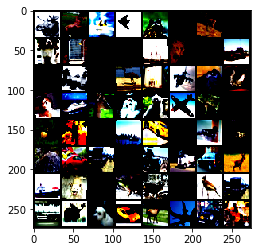

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample = next(iter(train_loader))[0]
show(torchvision.utils.make_grid(sample))
print(sample.shape)  

In [ ]:
from model import *
criterion = nn.CrossEntropyLoss()
#Networks creation
net = WideResNet(28, 4, dropout_rate=0.2, num_classes=num_class)
net =net.cuda()
net_save = WideResNet(28, 4, dropout_rate=0.2, num_classes=num_class) # model where to save the results
net_save =net_save.cuda()

In [ ]:
# Training
def train(epoch,net,trainloader,learing_rate, log_interval=15):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learing_rate ))
    optimizer = optim.SGD(net.parameters(), lr=learing_rate, momentum=bn_momentum , weight_decay=5e-4)
    for batch_idx, (inputs, targets,index) in enumerate(trainloader):

        inputs, targets = inputs.cuda(), targets.cuda() # GPU settings
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)               # Forward Propagation
        loss = criterion(outputs, targets)  # Loss
        loss.backward()  # Backward Propagation
        optimizer.step() # Optimizer update

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(trainloader.dataset)//batch_size)+1, loss.item(), 100.*correct/total))


def test(epoch,net,testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(testloader):
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        
    acc = 100.*correct/total
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))
    return acc

        

In [ ]:
num_epochs = 120
lr = 0.03
best_acc=0
for epoch in range(num_epochs):


    train(epoch,net,train_loader,learing_rate = lr)
    acc =test(epoch,net,valid_loader)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        net_save.load_state_dict(net.state_dict(), strict=True)
        best_acc=acc


=> Training Epoch #0, LR=0.0300
| Epoch [  0/120] Iter[  1/ 47]		Loss: 2.0718 Acc@1: 18.750%
| Epoch [  0/120] Iter[ 16/ 47]		Loss: 2.0984 Acc@1: 17.676%
| Epoch [  0/120] Iter[ 31/ 47]		Loss: 1.9558 Acc@1: 19.355%
| Epoch [  0/120] Iter[ 46/ 47]		Loss: 1.9884 Acc@1: 20.279%

| Validation Epoch #0			Loss: 2.3032 Acc@1: 25.08%
| Saving Best model...			Top1 = 25.08%

=> Training Epoch #1, LR=0.0300
| Epoch [  1/120] Iter[  1/ 47]		Loss: 2.1987 Acc@1: 20.312%
| Epoch [  1/120] Iter[ 16/ 47]		Loss: 2.1232 Acc@1: 23.145%
| Epoch [  1/120] Iter[ 31/ 47]		Loss: 2.0053 Acc@1: 23.790%
| Epoch [  1/120] Iter[ 46/ 47]		Loss: 2.0073 Acc@1: 23.743%

| Validation Epoch #1			Loss: 1.8817 Acc@1: 26.76%
| Saving Best model...			Top1 = 26.76%

=> Training Epoch #2, LR=0.0300
| Epoch [  2/120] Iter[  1/ 47]		Loss: 1.8433 Acc@1: 26.562%
| Epoch [  2/120] Iter[ 16/ 47]		Loss: 1.9956 Acc@1: 26.270%
| Epoch [  2/120] Iter[ 31/ 47]		Loss: 2.0357 Acc@1: 24.143%
| Epoch [  2/120] Iter[ 46/ 47]		Loss: 1.9554 Ac

In [ ]:
weak_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])


x_pseudolabeled = np.empty(shape = [0,32,32,3])
y_pseudolabeled = np.empty(shape = [0,])

# Dataset where we will save the new data with pseudolabels
pseudolabel_dataset = Dataset_sub_CIFAR(x_pseudolabeled , y_pseudolabeled, transform=strong_transform_train)

In [ ]:
def get_pseudolabels(pseudolabel_dataset, x_unlabeled, y_unlabeled, mu, thresh=0.9):
    
    #First we create a data loader with the remaining unlabeled data
    unloader = torch.utils.data.DataLoader(
        Dataset_sub_CIFAR(x_unlabeled, y_unlabeled, transform=weak_transform),
        batch_size = batch_size,
        shuffle=True, num_workers=2)

    #Create dictionary with images and the respective pseudolabel
    dic={}
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(unloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net_save(inputs)
            probs = torch.softmax(outputs, dim=1)
            scores, lbs = torch.max(probs, dim=1)
            idx = scores > thresh
            ind = index[idx].tolist()
            label = lbs[idx].tolist()
            for i in range(len(ind)):
                if ind[i] in dic:
                    if label[i]!=dic[ind[i]]:
                        print("Different Labels")
                else:
                    dic[ind[i]]=label[i]
                    
                    
    #Select mu*size samples with score greater then the thresh
    indexes = np.array(list(dic.keys()), dtype= int)
    select_idx = np.random.choice(indexes, size=min(2*(1000+len(pseudolabel_dataset)), len(indexes)), replace=False)
    
    #Get the data
    new_data = x_unlabeled[select_idx].astype('uint8')
    new_label = [dic.get(key) for key in select_idx]
    new_label = np.array(new_label).astype('int64')
    
    # Add the new data to the pseudolabeled dataset
    new_dataset = Dataset_sub_CIFAR(new_data , new_label, transform=strong_transform_train)
    pseudolabel_dataset = torch.utils.data.ConcatDataset([pseudolabel_dataset, new_dataset])
  
    # And then we remove the data from the unlabeled dataset
    x_unlabeled = np.delete(x_unlabeled, select_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, select_idx, axis=0)
    
    
    #Create a new dataloader with the pseudolabel dataset
    if len(new_dataset)>0:
        dataloader = torch.utils.data.DataLoader(pseudolabel_dataset, batch_size=32,shuffle=True, num_workers=1) #num_workers = 2 ou 1
    else:
        dataloader= train_loader
    
    
    #Return the new pseudolabel dataset, the dataloader, and the unlabeled data and labels
    return pseudolabel_dataset, dataloader, x_unlabeled, y_unlabeled
    


In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
class WarmupCosineLrScheduler(_LRScheduler):
    '''
    This is different from official definition, this is implemented according to
    the paper of fix-match
    '''
    def __init__(
            self,
            optimizer,
            max_iter,
            warmup_iter,
            warmup_ratio=5e-4,
            warmup='exp',
            last_epoch=-1,
    ):
        self.max_iter = max_iter
        self.warmup_iter = warmup_iter
        self.warmup_ratio = warmup_ratio
        self.warmup = warmup
        super(WarmupCosineLrScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        ratio = self.get_lr_ratio()
        lrs = [ratio * lr for lr in self.base_lrs]
        return lrs

    def get_lr_ratio(self):
        if self.last_epoch < self.warmup_iter:
            ratio = self.get_warmup_ratio()
        else:
            real_iter = self.last_epoch - self.warmup_iter
            real_max_iter = self.max_iter - self.warmup_iter
            ratio = np.cos((7 * np.pi * real_iter) / (16 * real_max_iter))
        return ratio

    def get_warmup_ratio(self):
        assert self.warmup in ('linear', 'exp')
        alpha = self.last_epoch / self.warmup_iter
        if self.warmup == 'linear':
            ratio = self.warmup_ratio + (1 - self.warmup_ratio) * alpha
        elif self.warmup == 'exp':
            ratio = self.warmup_ratio ** (1. - alpha)
        return ratio


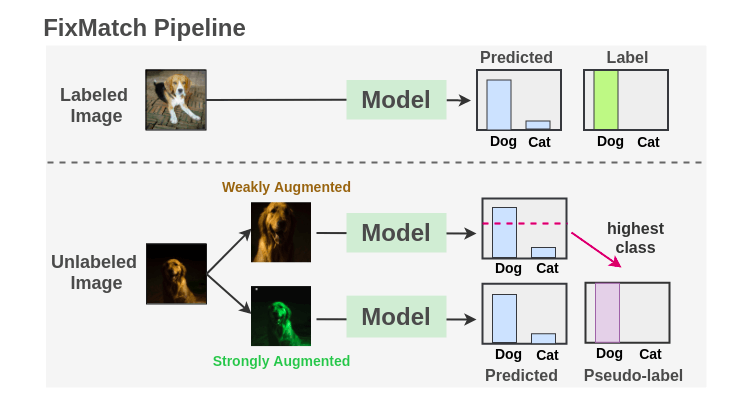

In [ ]:
# Training
def train(epoch,net, trainloader, new_trainloader, learning_rate, log_interval=15, lamb = 1):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate))
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=bn_momentum , weight_decay=0.0004)
    for batch_idx, data in enumerate(zip(train_loader, new_trainloader)):
        
        (inputs_x, targets_x , index_x), (inputs_u, targets_u , index_u) = data
        # GPU settings
        inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda()
        inputs_u, targets_u = inputs_u.cuda(), targets_u.cuda() 
        
        #Data 
        inputs_x, targets_x = Variable(inputs_x), Variable(targets_x)
        inputs_u, targets_u = Variable(inputs_u), Variable(targets_u)

        
        optimizer.zero_grad()
        outputs_x = net(inputs_x)               # Forward Propagation
        outputs_u = net(inputs_u)               
        
        # Loss for each type of data and final loss
        loss_x = criterion(outputs_x, targets_x)  
        loss_u = criterion(outputs_u, targets_u) 
        loss = loss_x + lamb* loss_u
        # Loss
        loss.backward()  # Backward Propagation
        optimizer.step() # Optimizer update

        train_loss += loss.item()
        _, predicted_x = torch.max(outputs_x.data, 1)
        _, predicted_u = torch.max(outputs_u.data, 1)
        total += targets_x.size(0)
        total += targets_u.size(0)
        correct += predicted_x.eq(targets_x.data).cpu().sum()
        correct += predicted_u.eq(targets_u.data).cpu().sum()
        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    ((len(new_trainloader.dataset)//batch_size)+(len(trainloader.dataset)//batch_size))+1, loss.item(), 100.*correct/total))

In [ ]:
mu = 2
batch_size = 64
num_epochs=1080
bn_momentum = 0.9
l_thresh = np.linspace(0.98, 0.95 , num=num_epochs)

In [ ]:
op = optim.SGD(net.parameters(), lr=0.06, momentum=bn_momentum , weight_decay=0.0004)
lr_scheduler = WarmupCosineLrScheduler(op, 1080, 0, 0.06, 'linear', -1)
net.load_state_dict(net_save.state_dict(), strict=True)
for epoch in range(num_epochs):
    if(epoch%120==0):
        pseudolabel_dataset , new_train_loader , x_unlabeled, y_unlabeled = get_pseudolabels(pseudolabel_dataset, x_unlabeled, y_unlabeled, mu=2, thresh= 0.95)
        print('| New Samples', len(new_train_loader.dataset) )
    
    train(epoch, net, train_loader, new_train_loader, learning_rate=lr_scheduler.get_lr()[0], lamb = 1)
    lr_scheduler.step()
    acc =test(epoch,net,valid_loader)
    # Save checkpoint when best model
    if acc > best_acc:
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
        net_save.load_state_dict(net.state_dict(), strict=True)
        best_acc=acc


=> Training Epoch #1, LR=0.0600
| Epoch [  1/1080] Iter[  1/234]		Loss: 2.8198 Acc@1: 55.208%
| Epoch [  1/1080] Iter[ 16/234]		Loss: 3.3248 Acc@1: 52.604%
| Epoch [  1/1080] Iter[ 31/234]		Loss: 3.0482 Acc@1: 52.319%
| Epoch [  1/1080] Iter[ 46/234]		Loss: 2.8828 Acc@1: 52.627%


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


A saída de streaming foi truncada nas últimas 5000 linhas.
=> Training Epoch #225, LR=0.0576
| Epoch [225/1080] Iter[  1/370]		Loss: 2.7253 Acc@1: 60.417%
| Epoch [225/1080] Iter[ 16/370]		Loss: 2.8761 Acc@1: 55.534%
| Epoch [225/1080] Iter[ 31/370]		Loss: 2.9024 Acc@1: 55.309%
| Epoch [225/1080] Iter[ 46/370]		Loss: 2.7871 Acc@1: 54.348%

| Validation Epoch #225			Loss: 0.3426 Acc@1: 64.44%

=> Training Epoch #226, LR=0.0576
| Epoch [226/1080] Iter[  1/370]		Loss: 2.6031 Acc@1: 58.333%
| Epoch [226/1080] Iter[ 16/370]		Loss: 2.8935 Acc@1: 54.362%
| Epoch [226/1080] Iter[ 31/370]		Loss: 2.8860 Acc@1: 53.965%
| Epoch [226/1080] Iter[ 46/370]		Loss: 2.8386 Acc@1: 53.623%

| Validation Epoch #226			Loss: 0.0015 Acc@1: 63.30%

=> Training Epoch #227, LR=0.0575
| Epoch [227/1080] Iter[  1/370]		Loss: 2.8319 Acc@1: 56.250%
| Epoch [227/1080] Iter[ 16/370]		Loss: 2.7462 Acc@1: 54.818%
| Epoch [227/1080] Iter[ 31/370]		Loss: 2.5571 Acc@1: 53.864%
| Epoch [227/1080] Iter[ 46/370]		Loss: 2.8499 

In [ ]:
import pandas as pd


def test_final(net,testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets,index) in enumerate(testloader):
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            if batch_idx == 0:
                predicted_concat = predicted.clone()
            else:
                predicted_concat = torch.cat((predicted_concat, predicted), 0)

        # Save checkpoint when best model
    acc = 100.*correct/total
    print("\n| TEST \t\t\tLoss: %.4f Acc@1: %.2f%%" %( loss.item(), acc))
    return predicted_concat.cpu().numpy()
    

predicted_concat = test_final(net_save,test_loader)


id_concat =range(len(predicted_concat))
my_submission = pd.DataFrame({'Id': id_concat,'Expected': predicted_concat})

# you could use any filename. We choose submission here
my_submission.to_csv('submission2.csv', index=False)
print('We have saved the submission !! ')